In [1]:
import skimage.io, skimage.color
import numpy
import matplotlib.pyplot
from matplotlib import pyplot as plt

def HOG_calculate_gradient(img, template):
    ts = template.size #Number of elements in the template (3).
    #New padded array to hold the resultant gradient image.
    new_img = numpy.zeros((img.shape[0]+ts-1, 
                           img.shape[1]+ts-1))
    new_img[numpy.uint16((ts-1)/2.0):img.shape[0]+numpy.uint16((ts-1)/2.0), 
            numpy.uint16((ts-1)/2.0):img.shape[1]+numpy.uint16((ts-1)/2.0)] = img
    result = numpy.zeros((new_img.shape))
    
    for r in numpy.uint16(numpy.arange((ts-1)/2.0, img.shape[0]+(ts-1)/2.0)):
        for c in numpy.uint16(numpy.arange((ts-1)/2.0, 
                              img.shape[1]+(ts-1)/2.0)):
            curr_region = new_img[r-numpy.uint16((ts-1)/2.0):r+numpy.uint16((ts-1)/2.0)+1, 
                                  c-numpy.uint16((ts-1)/2.0):c+numpy.uint16((ts-1)/2.0)+1]
            curr_result = curr_region * template
            score = numpy.sum(curr_result)
            result[r, c] = score
    #Result of the same size as the original image after removing the padding.
    result_img = result[numpy.uint16((ts-1)/2.0):result.shape[0]-numpy.uint16((ts-1)/2.0), 
                        numpy.uint16((ts-1)/2.0):result.shape[1]-numpy.uint16((ts-1)/2.0)]
    return result_img

def HOG_gradient_magnitude(horizontal_gradient, vertical_gradient):
    horizontal_gradient_square = numpy.power(horizontal_gradient, 2)
    vertical_gradient_square = numpy.power(vertical_gradient, 2)
    sum_squares = horizontal_gradient_square + vertical_gradient_square
    grad_magnitude = numpy.sqrt(sum_squares)
    return grad_magnitude

def HOG_gradient_direction(horizontal_gradient, vertical_gradient):
    grad_direction = numpy.arctan(vertical_gradient/(horizontal_gradient+0.00000001))
    grad_direction = numpy.rad2deg(grad_direction)
    grad_direction = grad_direction%180
    return grad_direction

def HOG_HOG_cell_histogram(cell_direction, cell_magnitude, hist_bins):
    HOG_cell_hist = numpy.zeros(shape=(hist_bins.size))
    cell_size = cell_direction.shape[0]
    
    for row_idx in range(cell_size):
        for col_idx in range(cell_size):
            curr_direction = cell_direction[row_idx, col_idx]
            curr_magnitude = cell_magnitude[row_idx, col_idx]
    
            diff = numpy.abs(curr_direction - hist_bins)
            
            if curr_direction < hist_bins[0]:
                first_bin_idx = 0
                second_bin_idx = hist_bins.size-1
            elif curr_direction > hist_bins[-1]:
                first_bin_idx = hist_bins.size-1
                second_bin_idx = 0
            else:
                first_bin_idx = numpy.where(diff == numpy.min(diff))[0][0]
                temp = hist_bins[[(first_bin_idx-1)%hist_bins.size, (first_bin_idx+1)%hist_bins.size]]
                temp2 = numpy.abs(curr_direction - temp)
                res = numpy.where(temp2 == numpy.min(temp2))[0][0]
                if res == 0 and first_bin_idx != 0:
                    second_bin_idx = first_bin_idx-1
                else:
                    second_bin_idx = first_bin_idx+1
            
            first_bin_value = hist_bins[first_bin_idx]
            second_bin_value = hist_bins[second_bin_idx]
            HOG_cell_hist[first_bin_idx] = HOG_cell_hist[first_bin_idx] + (numpy.abs(curr_direction - first_bin_value)/(180.0/hist_bins.size)) * curr_magnitude
            HOG_cell_hist[second_bin_idx] = HOG_cell_hist[second_bin_idx] + (numpy.abs(curr_direction - second_bin_value)/(180.0/hist_bins.size)) * curr_magnitude
    return HOG_cell_hist

<ipython-input-2-cf34dd86a674>:2: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  img = skimage.color.rgb2gray(img)


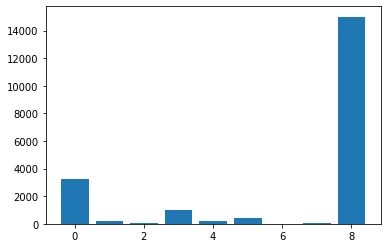

In [2]:
img = skimage.io.imread("im_patch.jpg")
img = skimage.color.rgb2gray(img)

horizontal_mask = numpy.array([-1, 0, 1])
vertical_mask = numpy.array([[-1],
                             [0],
                             [1]])

horizontal_gradient = HOG_calculate_gradient(img, horizontal_mask)
vertical_gradient = HOG_calculate_gradient(img, vertical_mask)

grad_magnitude = HOG_gradient_magnitude(horizontal_gradient, vertical_gradient)
grad_direction = HOG_gradient_direction(horizontal_gradient, vertical_gradient)

grad_direction = grad_direction % 180
hist_bins = numpy.array([10,30,50,70,90,110,130,150,170])

# Histogram of the first cell in the first block.
cell_direction = grad_direction[:8, :8]
cell_magnitude = grad_magnitude[:8, :8]
HOG_cell_hist = HOG_HOG_cell_histogram(cell_direction, cell_magnitude, hist_bins)

matplotlib.pyplot.bar(x=numpy.arange(9), height=HOG_cell_hist, align="center", width=0.8)
matplotlib.pyplot.show()

<function matplotlib.pyplot.show(close=None, block=None)>

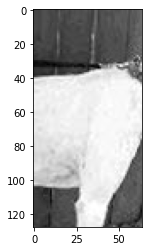

In [3]:
img = skimage.io.imread("im_patch.jpg")
plt.imshow(img, 'gray')
plt.show